# Resale price with latitude and longitude data

Using knowledge that I found on openmaps API article, I decided to give it a try to see if inputting raw latitude and longitude data can assist in making the model more robust. The csv was prepared for in "write new csv.py" , this was to save the latitude and longitude data so there will not be a need to request for lat and lon data every time.

I also intend to use this knowledge to further improve by adding new features such as distance to mrt, distance to malls, number of nearby malls, distance to town.

## 1. Import packages and getting the data

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from common_func import *
import math
from sklearn.model_selection import train_test_split
import tensorflow as tf
%matplotlib inline
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
# Read csv as dataframe

data = pd.read_csv('data/geo_coords_data.csv', parse_dates=True,index_col=0 )

In [5]:
#  describe data
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
storey_range,224463.0,8.405091,5.641079,2.000000,5.000000,8.000000,11.000000,5.000000e+01
floor_area_sqm,224463.0,97.271200,24.329626,31.000000,76.000000,95.000000,112.000000,2.800000e+02
resale_price,224463.0,463256.760303,150795.112175,140000.000000,355000.000000,435000.000000,540000.000000,1.418000e+06
remaining_lease_year,224463.0,74.448621,12.388411,43.250738,64.669384,73.671622,84.250895,9.783639e+01
LAT,224463.0,1.366286,0.042754,1.270380,1.336285,1.364647,1.393629,1.457071e+00
LONG,224463.0,103.840507,0.072144,103.685228,103.776710,103.845626,103.899249,1.039878e+02


In [6]:
data.dtypes

month                    object
town                     object
flat_type                object
storey_range            float64
floor_area_sqm          float64
flat_model               object
resale_price            float64
lease_commence_dt        object
remaining_lease_year    float64
LAT                     float64
LONG                    float64
dtype: object

In [7]:
data.head(5)

,month,town,flat_type,storey_range,floor_area_sqm,flat_model,resale_price,lease_commence_dt,remaining_lease_year,LAT,LONG
0,2012-03-01,ANG MO KIO,2 ROOM,8.0,45.0,Improved,250000.0,1986-01-01,72.836561,1.374694,103.836463
1,2012-03-01,ANG MO KIO,2 ROOM,3.0,44.0,Improved,265000.0,1980-01-01,66.835068,1.373401,103.849073
2,2012-03-01,ANG MO KIO,3 ROOM,8.0,68.0,New Generation,315000.0,1980-01-01,66.835068,1.379395,103.839157
3,2012-03-01,ANG MO KIO,3 ROOM,3.0,67.0,New Generation,320000.0,1984-01-01,70.835151,1.362758,103.858015
4,2012-03-01,ANG MO KIO,3 ROOM,8.0,67.0,New Generation,321000.0,1980-01-01,66.835068,1.379867,103.835977


In [8]:
data.groupby("flat_type")[['resale_price','floor_area_sqm']].agg([np.mean,np.median])

resale_price           floor_area_sqm       
                           mean    median           mean median
flat_type                                                      
1 ROOM            208529.709091  210000.0      31.000000   31.0
2 ROOM            252781.063815  250000.0      45.828921   46.0
3 ROOM            333658.000892  322000.0      68.180607   67.0
4 ROOM            459850.769344  432000.0      95.470284   93.0
5 ROOM            553968.728887  518000.0     118.071744  119.0
EXECUTIVE         651415.164864  630000.0     144.341030  145.0
MULTI-GENERATION  798068.782609  790000.0     160.152174  164.0

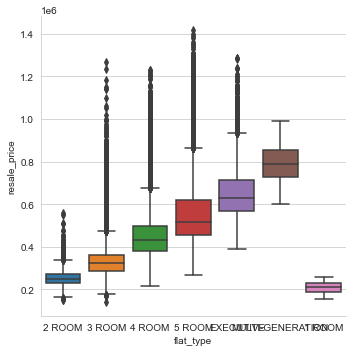

In [9]:

ax = sns.catplot(x='flat_type',y='resale_price',data = data,kind ='box')

### Creating the distance from lat and lon

Latitude and longitude of central area is about 1.300556, 103.821667 (source:wiki), using this info we can calculate the distance to town

In [13]:
# conversion represents 111km: 1deg

conversion = 111

In [14]:
central = np.array([1.300556, 103.821667])
# find distance to town

coords_array = data[['LAT','LONG']].to_numpy()

In [15]:
data['distance_to_town']= np.linalg.norm(coords_array - central,axis=1)*conversion

In [16]:
mrt = pd.read_csv('amenities/mrt.csv')
malls = pd.read_csv('amenities/malls.csv')

In [17]:
mrt_array = mrt[['LAT','LONG']].to_numpy()
malls_array = malls[['LAT','LONG']].to_numpy()

## Getting info from our lat and long data

In [18]:
%%time
# let's set some conditions
# nearest mrt and number of malls

distance_to_mrt = np.empty((len(coords_array),1))
for index,coords in enumerate(coords_array):
    distance_to_mrt[index] = min(np.linalg.norm(coords - mrt_array,axis=1))*conversion
data['distance_to_mrt'] = distance_to_mrt

CPU times: total: 2.75 s
Wall time: 2.87 s


In [19]:
%%time

distance_to_mall = np.empty((len(coords_array),1))
for index,coords in enumerate(coords_array):
    distance_to_mall[index] = min(np.linalg.norm(coords - malls_array,axis=1))*conversion
data['distance_to_mall'] = distance_to_mall

CPU times: total: 2.12 s
Wall time: 2.2 s


In [20]:
max_distance = max(distance_to_mall)
print(f"Max distance from one mall to flat is {max_distance[0]:.4f}km")

Max distance from one mall to flat is 3.2023km


In [21]:
%%time

# Rational of using max distance is to set it as the reference
radius = math.ceil(max_distance[0])/conversion
number_of_malls = np.empty((len(coords_array),1))
for index,coords in enumerate(coords_array):
    number_of_malls[index] = (np.linalg.norm(coords- malls_array,axis=1)<radius).sum()

data['number_of_malls'] = number_of_malls

CPU times: total: 1.95 s
Wall time: 2.01 s


In [23]:
data.sort_values(by="number_of_malls",ascending=False).head()

,month,town,flat_type,storey_range,floor_area_sqm,flat_model,resale_price,lease_commence_dt,remaining_lease_year,LAT,LONG,distance_to_town,distance_to_mrt,distance_to_mall,number_of_malls
38559,2014-03-01,CENTRAL AREA,3 ROOM,2.0,81.0,Model A,405000.0,1984-01-01,68.836479,1.307435,103.854714,3.746846,0.259479,0.300752,43.0
175049,2020-12-01,CENTRAL AREA,3 ROOM,11.0,68.0,Improved,440800.0,1986-01-01,64.083472,1.299009,103.852285,3.402920,0.214594,0.354919,43.0
193850,2021-08-01,CENTRAL AREA,3 ROOM,5.0,73.0,Model A,420000.0,1985-01-01,62.418824,1.305707,103.854943,3.737650,0.071143,0.365286,43.0
193847,2021-08-01,CENTRAL AREA,3 ROOM,5.0,58.0,Standard,330000.0,1974-01-01,51.417914,1.303461,103.850709,3.239783,0.232760,0.263089,43.0
193846,2021-08-01,CENTRAL AREA,3 ROOM,11.0,56.0,Standard,363000.0,1974-01-01,51.417914,1.303461,103.850709,3.239783,0.232760,0.263089,43.0


In [24]:
data['year'] = pd.to_datetime(data['month']).dt.year

In [25]:
#Drop lease_commence_dt
y = data['resale_price']
data_final = data.drop(columns=['town','lease_commence_dt','month','resale_price','LAT','LONG'],axis=1)

In [26]:
# Create dummies variables and map room sizes to number. The room numbers are found on the hdb website.
# For 5 rooms, there's an additional area catered for a study room, however due to its size, I mapped it to
# the value of 4.5
#
dummies = ['flat_model']
data_final['flat_cat'] = data_final.flat_type.map({'2 ROOM':2,
                                                   '3 ROOM':3,
                                                   '4 ROOM':4,
                                                   '5 ROOM': 5,
                                                   '1 ROOM':1,
                                                   'EXECUTIVE': 6,
                                                    'MULTI-GENERATION':7})
data_dummies = pd.get_dummies(data_final,columns=dummies,drop_first=True)

In [27]:

data_dummies = data_dummies.drop(columns='flat_type') # Drop 'flat_type'
data_dummies.head(5)

,storey_range,floor_area_sqm,remaining_lease_year,distance_to_town,distance_to_mrt,distance_to_mall,number_of_malls,year,flat_cat,flat_model_3Gen,...,flat_model_Multi Generation,flat_model_New Generation,flat_model_Premium Apartment,flat_model_Premium Apartment Loft,flat_model_Premium Maisonette,flat_model_Simplified,flat_model_Standard,flat_model_Terrace,flat_model_Type S1,flat_model_Type S2
0,8.0,45.0,72.836561,8.391626,1.225290,1.457889,3.0,2012,2,0,...,0,0,0,0,0,0,0,0,0,0
1,3.0,44.0,66.835068,8.639114,0.388701,0.450175,5.0,2012,2,0,...,0,0,0,0,0,0,0,0,0,0
2,8.0,68.0,66.835068,8.963859,0.694080,1.517844,3.0,2012,3,0,...,0,1,0,0,0,0,0,0,0,0
3,3.0,67.0,70.835151,7.996832,1.231076,1.289399,7.0,2012,3,0,...,0,1,0,0,0,0,0,0,0,0
4,8.0,67.0,66.835068,8.945618,1.017583,1.810552,3.0,2012,3,0,...,0,1,0,0,0,0,0,0,0,0


In [34]:
# Create X and y variables
X= data_dummies

## Feature importances using ExtraTreesRegressor

In [35]:
from sklearn.ensemble import ExtraTreesRegressor

sel=ExtraTreesRegressor(n_estimators=50)

sel.fit(X,y)

ExtraTreesRegressor(n_estimators=50)

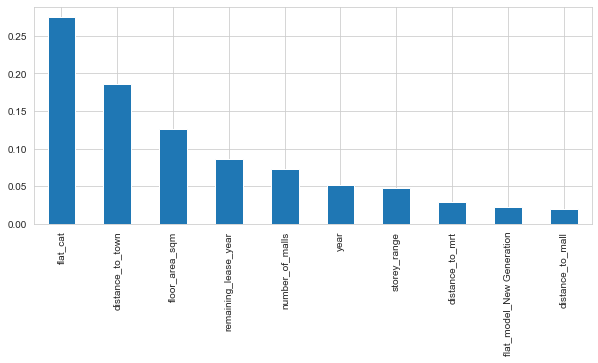

In [36]:
plt.figure(figsize = (10,4))
feat_impt = pd.Series(sel.feature_importances_, index=X.columns)
feat_impt.nlargest(10).plot(kind='bar')
plt.show()

First is flat cat, and we can observe that distance_to_town has the second highest importance, which seems logical as houses get more expensive the nearer to town.

we will drop all dummies of flat_model as it does not contribute much

## Features selection

In [37]:
data_final.head()

,flat_type,storey_range,floor_area_sqm,flat_model,remaining_lease_year,distance_to_town,distance_to_mrt,distance_to_mall,number_of_malls,year,flat_cat
0,2 ROOM,8.0,45.0,Improved,72.836561,8.391626,1.225290,1.457889,3.0,2012,2
1,2 ROOM,3.0,44.0,Improved,66.835068,8.639114,0.388701,0.450175,5.0,2012,2
2,3 ROOM,8.0,68.0,New Generation,66.835068,8.963859,0.694080,1.517844,3.0,2012,3
3,3 ROOM,3.0,67.0,New Generation,70.835151,7.996832,1.231076,1.289399,7.0,2012,3
4,3 ROOM,8.0,67.0,New Generation,66.835068,8.945618,1.017583,1.810552,3.0,2012,3


In [38]:
# drop unnessary columns

X1 = data_final.drop(columns=['flat_type','flat_model'])

In [39]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X1,y,test_size=0.2)

# Model building

## Random Forest Regressor

In [40]:
from sklearn.ensemble import RandomForestRegressor
rtree=RandomForestRegressor(n_estimators=200,random_state=42)

In [41]:
rtree.fit(X_train,y_train)

RandomForestRegressor(n_estimators=200, random_state=42)

In [42]:
y_pred_rf = rtree.predict(X_test)

### Get metrics

In [43]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
def print_metrics(actual:pd.DataFrame,pred:pd.DataFrame,model_name:str) -> dict:
    mae = mean_absolute_error(actual,pred)
    rmse = np.sqrt(mean_squared_error(actual,pred))
    rs = r2_score(actual,pred)
    print(f"Scores for {model_name.upper()}\n"
          f"Mean absolute error: {mae}\n"
          f"RMSE: {rmse}\n"
          f"R score: {rs}\n")
    return {"Model": model_name.upper(),"MAE": mae, "RMSE": rmse, "R score": rs}

In [44]:
print_metrics(y_test,y_pred_rf,"Random Forest")

Scores for RANDOM FOREST
Mean absolute error: 18525.23689644646
RMSE: 26366.759998909878
R score: 0.9693699465204636



{'Model': 'RANDOM FOREST',
 'MAE': 18525.23689644646,
 'RMSE': 26366.759998909878,
 'R score': 0.9693699465204636}

In [45]:
# Overfit check

print(rtree.score(X_train,y_train))
print(rtree.score(X_test,y_test))

0.9957760682076
0.9693699465204636


## Hyper-Parameter tuning with XGBoost and HalvingGridSearchCV

In [46]:
#Using halving grid
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
params = {
        'colsample_bytree': [0.5, 0.7,0.9],
        'max_depth': [7,9,11],
        'n_estimators' : [300, 400, 500, 600],
        'subsample' : [0.7,0.8,0.9],
        'objective': ['reg:squarederror']
    
        }

In [47]:
from xgboost import XGBRegressor
xgbooster = XGBRegressor()
gridxg = HalvingGridSearchCV(
                    estimator=xgbooster,
                    param_grid=params,
                    cv=3,
                    n_jobs=6,
                    verbose=1,
                    min_resources='exhaust',
    error_score ='raise'
)
gridxg.fit(X_train,y_train)

gridxg.best_params_

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 2216
max_resources_: 179570
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 108
n_resources: 2216
Fitting 3 folds for each of 108 candidates, totalling 324 fits
----------
iter: 4
n_candidates: 2
n_resources: 179496
Fitting 3 folds for each of 2 candidates, totalling 6 fits
----------
iter: 3
n_candidates: 4
n_resources: 59832
Fitting 3 folds for each of 4 candidates, totalling 12 fits
----------
iter: 1
n_candidates: 36
n_resources: 6648
Fitting 3 folds for each of 36 candidates, totalling 108 fits
----------
iter: 2
n_candidates: 12
n_resources: 19944
Fitting 3 folds for each of 12 candidates, totalling 36 fits


{'colsample_bytree': 0.7,
 'max_depth': 7,
 'n_estimators': 600,
 'objective': 'reg:squarederror',
 'subsample': 0.8}

In [48]:
xgb_model = XGBRegressor(
                objective='reg:squarederror',
                colsample_bytree=0.9,
                learning_rate=0.1,
                max_depth=7,
                n_estimators=600,
                subsample=0.8
                )
%time xgb_model.fit(X_train,y_train,early_stopping_rounds=5,eval_set=[(X_test,y_test)],verbose=False)

c:\users\wayne\.virtualenvs\162 test\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


CPU times: total: 3min 46s
Wall time: 30.2 s


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.9,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=7, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=600, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [49]:
y_pred_xgb = xgb_model.predict(X_test) # Fit model


In [50]:
#Overfit check

print(xgb_model.score(X_train,y_train))

print(xgb_model.score(X_test,y_test))

0.9800430567537908
0.9722922999595943


# Let's try out DNN

In [51]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def build_and_compile_model(norm):
    model = keras.Sequential([
        norm,
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])

    model.compile(loss='mean_squared_error',
                  optimizer=tf.keras.optimizers.Adam(0.001))

    return model

In [52]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(X_train))
print(normalizer.mean.numpy())
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

[[8.4178391e+00 9.7258980e+01 7.4441742e+01 1.1301194e+01 8.1216133e-01
  9.7684407e-01 8.1692419e+00 2.0173428e+03 4.1213140e+00]]
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 9)                19        
 n)                                                              
                                                                 
 dense (Dense)               (None, 64)                640       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                        

In [53]:
from tensorflow.keras.callbacks import EarlyStopping


early_stopping = EarlyStopping(monitor= 'val_loss',patience=5)

In [54]:
%%time
history = dnn_model.fit(
    X_train,
    y_train,
    validation_split=0.25,
    verbose=1,
    epochs=100,
    batch_size = 128,
    callbacks=[early_stopping])

Epoch 1/100
1053/1053 [==============================] - 7s 4ms/step - loss: 101539995648.0000 - val_loss: 10871970816.0000
Epoch 2/100
1053/1053 [==============================] - 4s 4ms/step - loss: 7380371968.0000 - val_loss: 5254398464.0000
Epoch 3/100
1053/1053 [==============================] - 4s 4ms/step - loss: 4585805824.0000 - val_loss: 3989596672.0000
Epoch 4/100
1053/1053 [==============================] - 4s 4ms/step - loss: 3837297920.0000 - val_loss: 3595478528.0000
Epoch 5/100
1053/1053 [==============================] - 4s 4ms/step - loss: 3570681600.0000 - val_loss: 3432982528.0000
Epoch 6/100
1053/1053 [==============================] - 4s 4ms/step - loss: 3425068288.0000 - val_loss: 3296705280.0000
Epoch 7/100
1053/1053 [==============================] - 4s 4ms/step - loss: 3305957120.0000 - val_loss: 3185650688.0000
Epoch 8/100
1053/1053 [==============================] - 4s 4ms/step - loss: 3196530432.0000 - val_loss: 3079534592.0000
Epoch 9/100
1053/1053 [======

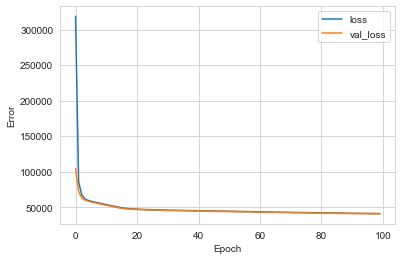

In [55]:
def plot_loss(history):
    plt.plot(np.sqrt(history.history['loss']), label='loss')
    plt.plot(np.sqrt(history.history['val_loss']), label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)
plot_loss(history)

1403/1403 [==============================] - 1s 1ms/step


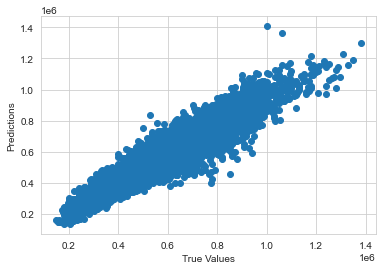

In [99]:
y_pred_dnn = dnn_model.predict(X_test).flatten()

plt.scatter(y_test, y_pred_dnn)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()

# Model evaluation

In [100]:
# XGB
print_metrics(y_test,y_pred_xgb,"XGB")
print_metrics(y_test,y_pred_rf,"RF")
print_metrics(y_test,y_pred_dnn,"DNN")

Scores for XGB
Mean absolute error: 18265.141304657744
RMSE: 25077.435798475002
R score: 0.9722922999595943

Scores for RF
Mean absolute error: 18525.23689644646
RMSE: 26366.759998909878
R score: 0.9693699465204636

Scores for DNN
Mean absolute error: 29535.983189458824
RMSE: 41229.84987138979
R score: 0.9251041541777736



{'Model': 'DNN',
 'MAE': 29535.983189458824,
 'RMSE': 41229.84987138979,
 'R score': 0.9251041541777736}

<AxesSubplot:title={'center':'DNN'}, xlabel='resale_price', ylabel='Count'>

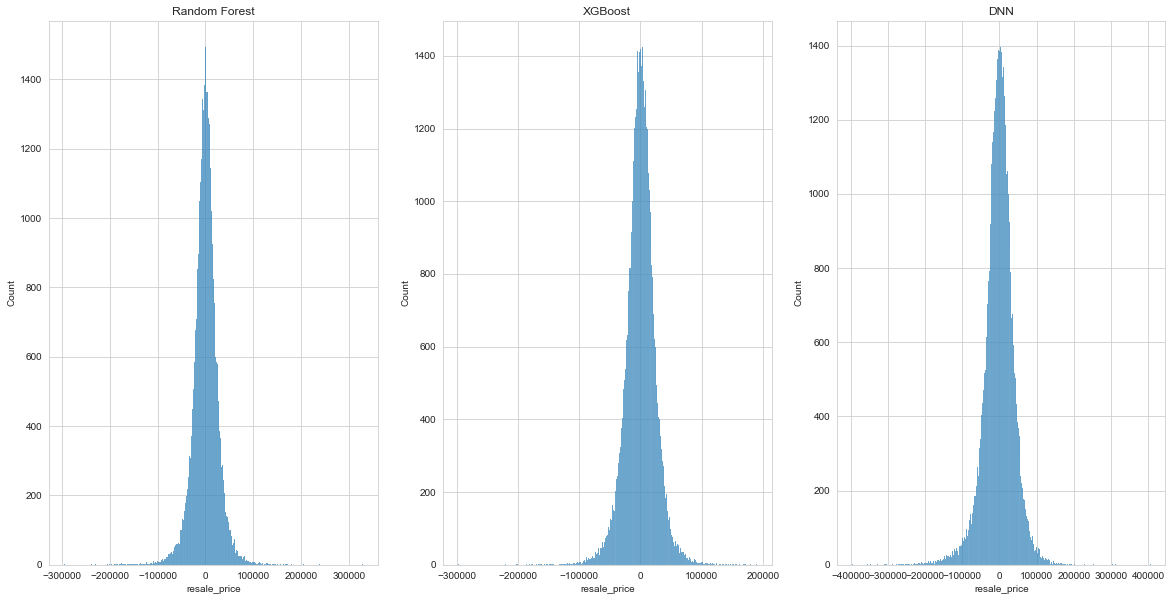

In [101]:
# Print the histplot of XGBoost and Random forest pred values for comparison
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize = (20,10))
ax1.set_title('Random Forest')
ax2.set_title('XGBoost')
ax3.set_title('DNN')
sns.histplot(y_pred_rf-y_test,ax=ax1,)
sns.histplot(y_pred_xgb-y_test,ax=ax2)
sns.histplot(y_pred_dnn-y_test, ax= ax3)

In [102]:
# Make into a dataframe
d = {"Random Forest": y_pred_rf, "XGBRegressor": y_pred_xgb, "DNN":y_pred_dnn, "Actual":y_test}
df_y = pd.DataFrame.from_dict(d)

In [103]:
df_y.head()

,Random Forest,XGBRegressor,DNN,Actual
194164,308393.320000,306604.3750,294450.65625,328000.0
213663,573155.440000,589493.9375,572840.56250,588000.0
102744,301664.593333,292516.3750,279863.46875,288888.0
53513,622118.210000,631209.3125,622003.56250,635000.0
36192,346204.000000,340014.9375,350501.71875,345000.0


In [104]:
# This finds the absolute biggest % difference between the models

max_diff_rt = ((df_y['Actual']-df_y['Random Forest'])/(df_y['Actual'])).abs().max()
max_diff_xgb =((df_y['Actual']-df_y['XGBRegressor'])/(df_y['Actual'])).abs().max()
max_diff_dnn =((df_y['Actual']-df_y['DNN'])/(df_y['Actual'])).abs().max()

print("Max difference in price for random forest is : ",max_diff_rt
     ,"\nMax difference in price for XGB is : " , max_diff_xgb
      ,"\nMax difference in price for DNN is : " , max_diff_dnn)

Max difference in price for random forest is :  0.6129698598130842 
Max difference in price for XGB is :  0.536390625 
Max difference in price for DNN is :  0.5876460700757575


In [105]:
# This finds and prints the row with the biggest % difference
# after that compares how differently they predict the values

rt_diff_index = ((df_y['Actual']-df_y['Random Forest'])/(df_y['Actual'])).abs().idxmax()
xgb_diff_index =((df_y['Actual']-df_y['XGBRegressor'])/(df_y['Actual'])).abs().idxmax()
dnn_diff_index = ((df_y['Actual']-df_y['DNN'])/(df_y['Actual'])).abs().idxmax()
print("Row with greatest difference:")
print(df_y.loc[[rt_diff_index]])
print(df_y.loc[[xgb_diff_index]])
print(df_y.loc[[dnn_diff_index]])


Row with greatest difference:
        Random Forest  XGBRegressor         DNN    Actual
215247     862938.875    686481.125  724734.625  535000.0
        Random Forest  XGBRegressor           DNN    Actual
106621       322735.0   338005.9375  349007.71875  220000.0
       Random Forest  XGBRegressor         DNN    Actual
46893      561449.14     546963.75  838277.125  528000.0


## Experimentation and learning keras-tuner

In [78]:
import keras_tuner as kt

In [80]:
def model_builder(hp,norm=normalizer):
    model = keras.Sequential()

    model.add(norm)

    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
    model.add(keras.layers.Dense(units=hp_units, activation='relu'))
    model.add(keras.layers.Dense(1))

    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss="mean_squared_error",
                  metrics = "mean_squared_error")

    return model

In [81]:
hyperband = kt.Hyperband(model_builder,
                     objective= "mean_squared_error",
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt1')
early_stopping = EarlyStopping(monitor= 'mean_squared_error',patience=5)

In [82]:
hyperband.search(X_train,
             y_train,
             epochs = 50,
             validation_split=0.2,
             callbacks=[early_stopping])

Trial 30 Complete [00h 01m 56s]
mean_squared_error: 8358725120.0

Best mean_squared_error So Far: 2922392576.0
Total elapsed time: 00h 24m 18s
INFO:tensorflow:Oracle triggered exit


In [83]:
# Get the optimal hyperparameters
best_hps=hyperband.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")


The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 320 and the optimal learning rate for the optimizer
is 0.01.



## Build model with parameters

In [84]:
hyperband_model = hyperband.hypermodel.build(best_hps)
history_hyperband = hyperband_model.fit(X_train,
                                        y_train,
                                        epochs = 100,
                                        validation_split = 0.2,
                                        batch_size= 128)



Epoch 1/100
1123/1123 [==============================] - 3s 2ms/step - loss: 183309320192.0000 - mean_squared_error: 183309320192.0000 - val_loss: 99473940480.0000 - val_mean_squared_error: 99473940480.0000
Epoch 2/100
1123/1123 [==============================] - 3s 2ms/step - loss: 51943727104.0000 - mean_squared_error: 51943727104.0000 - val_loss: 27461466112.0000 - val_mean_squared_error: 27461466112.0000
Epoch 3/100
1123/1123 [==============================] - 3s 2ms/step - loss: 20259309568.0000 - mean_squared_error: 20259309568.0000 - val_loss: 14622630912.0000 - val_mean_squared_error: 14622630912.0000
Epoch 4/100
1123/1123 [==============================] - 3s 2ms/step - loss: 10867665920.0000 - mean_squared_error: 10867665920.0000 - val_loss: 7953088000.0000 - val_mean_squared_error: 7953088000.0000
Epoch 5/100
1123/1123 [==============================] - 3s 2ms/step - loss: 6343052288.0000 - mean_squared_error: 6343052288.0000 - val_loss: 5162886656.0000 - val_mean_squared_er

In [85]:
val_loss_per_epoch = history_hyperband.history['val_mean_squared_error']
best_epoch = val_loss_per_epoch.index(min(val_loss_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Best epoch: 99


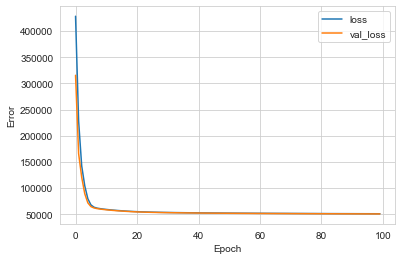

In [86]:
plot_loss(history_hyperband)

In [87]:
y_pred_hyperband = hyperband_model.predict(X_test)

1403/1403 [==============================] - 1s 767us/step


In [97]:
print_metrics(y_test,y_pred_hyperband,"hyperband")

Scores for HYPERBAND
Mean absolute error: 37017.3765812042
RMSE: 51668.7352835755
R score: 0.8823776409393271



{'Model': 'HYPERBAND',
 'MAE': 37017.3765812042,
 'RMSE': 51668.7352835755,
 'R score': 0.8823776409393271}

# Conclusion + Summary of models

It doesn't seem that NN is worth the effort and computing power to train a NN, perhaps my knowledge of NN is not deep enough

## Comparison of scores

In [91]:
list_of_predictions = [y_pred_rf,y_pred_xgb,y_pred_dnn,y_pred_hyperband]
name = ['rf','xgb','dnn','hyperband']

In [92]:
metrics_combined = []
for i in range(len(name)):
    metrics_combined.append(print_metrics(y_test,list_of_predictions[i],name[i]))

Scores for RF
Mean absolute error: 18525.23689644646
RMSE: 26366.759998909878
R score: 0.9693699465204636

Scores for XGB
Mean absolute error: 18265.141304657744
RMSE: 25077.435798475002
R score: 0.9722922999595943

Scores for DNN
Mean absolute error: 29535.980728398634
RMSE: 41229.847236843096
R score: 0.9251041637493145

Scores for HYPERBAND
Mean absolute error: 37017.3765812042
RMSE: 51668.7352835755
R score: 0.8823776409393271



In [95]:
Summary = pd.DataFrame(metrics_combined).set_index('Model')

In [96]:
Summary.transpose()

Model,RF,XGB,DNN,HYPERBAND
MAE,18525.236896,18265.141305,29535.980728,37017.376581
RMSE,26366.759999,25077.435798,41229.847237,51668.735284
R score,0.969370,0.972292,0.925104,0.882378
